In [148]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC


In [150]:
from collections import Counter

posts_df = pd.read_csv("Posts_Table_with_user_id.csv")
hashtag_df = pd.read_csv("Hashtag_Table.csv")
personality_df = pd.read_csv("Personality_Table.csv")

print("Files loaded")
print("Posts shape:", posts_df.shape)
print("Hashtag table shape:", hashtag_df.shape)
print("Personality table shape:", personality_df.shape)

Files loaded
Posts shape: (4649, 43)
Hashtag table shape: (25098, 4)
Personality table shape: (3609, 7)


In [152]:
hashtag_df["hashtag"] = (
    hashtag_df["hashtag"]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace("#", "", regex=False)
)

hashtag_lookup = hashtag_df.set_index("hashtag")[["category", "sentiment"]]

print("\nHashtag lookup sample:")
print(hashtag_lookup.head())
hashtag_lookup["sentiment"].value_counts()


Hashtag lookup sample:
                 category sentiment
hashtag                            
viral       Entertainment   Neutral
fyp                 Other   Neutral
reels       Entertainment   Neutral
explore   Travel & Nature   Neutral
trending    Entertainment   Neutral


sentiment
Neutral     24912
Positive      123
Negative       63
Name: count, dtype: int64

In [154]:
hashtag_cols = [c for c in posts_df.columns if c.startswith("hashtags/")]
print("\nHashtag columns found:", len(hashtag_cols))

combined = []

for i, row in posts_df.iterrows():
    tags = []
    for col in hashtag_cols:
        val = row[col]
        if pd.notna(val):
            tags.append(
                str(val)
                .lower()
                .strip()
                .replace("#", "")
            )
    combined.append(tags)

posts_df["combined_hashtags"] = combined

print("\nCombined hashtag sample:")
print(posts_df["combined_hashtags"].head())


Hashtag columns found: 31

Combined hashtag sample:
0    [cats, pettraining, luckythecat, animallove, c...
1    [blackwolfjo, تجربة_غير, petshopjo, عمان, كلشي...
2    [aquaanimalcarecenter, oceanside, animalhospit...
3    [1, allamericank9, azdogtraining, boardandtrai...
4    [dogs, dogtraining, adestramento, adestramento...
Name: combined_hashtags, dtype: object


In [156]:
def extract_features(tag_list, lookup):
    cat_counter = Counter()
    sent_counter = Counter()

    for tag in tag_list:
        if tag in lookup.index:
            row = lookup.loc[tag]

            # If multiple rows exist, take the first one
            if isinstance(row, pd.DataFrame):
                cat = row["category"].iloc[0]
                sent = row["sentiment"].iloc[0]
            else:
                cat = row["category"]
                sent = row["sentiment"]

            cat_counter[cat] += 1
            sent_counter[sent] += 1

    features = {}
    for k, v in cat_counter.items():
        features[f"cat_{k}"] = v
    for k, v in sent_counter.items():
        features[f"sent_{k}"] = v

    return features

post_features = posts_df["combined_hashtags"].apply(
    lambda tags: extract_features(tags, hashtag_lookup)
)

post_features_df = pd.json_normalize(post_features).fillna(0)

print("\nExtracted feature columns:")
print(post_features_df.columns.tolist())

print("Feature dataframe shape:", post_features_df.shape)
post_features_df


Extracted feature columns:
['cat_Pets & Animals', 'cat_Fitness & Health', 'cat_Other', 'sent_Neutral', 'cat_Technology & Programming', 'cat_Relationships', 'cat_Art & Creativity', 'cat_Home & Interior', 'cat_Fashion', 'cat_Education', 'cat_Motivation & Self-Improvement', 'cat_Cooking', 'cat_Travel & Nature', 'cat_Business & Finance', 'cat_Cars & Automobiles', 'sent_Positive', 'cat_Beauty & Personal Care', 'cat_Entertainment', 'cat_News & Politics', 'cat_Sports', 'cat_Gaming', 'sent_Negative']
Feature dataframe shape: (4649, 22)


,cat_Pets & Animals,cat_Fitness & Health,cat_Other,sent_Neutral,cat_Technology & Programming,cat_Relationships,cat_Art & Creativity,cat_Home & Interior,cat_Fashion,cat_Education,...,cat_Travel & Nature,cat_Business & Finance,cat_Cars & Automobiles,sent_Positive,cat_Beauty & Personal Care,cat_Entertainment,cat_News & Politics,cat_Sports,cat_Gaming,sent_Negative
0,3.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,1.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,6.0,2.0,21.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.0,3.0,16.0,29.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:


# 5. USER-LEVEL AGGREGATION

posts_enriched = pd.concat(
    [posts_df[["user_id"]], post_features_df],
    axis=1
)

user_features = posts_enriched.groupby("user_id").sum().reset_index()

print("\nUser-level features:")
print(user_features.head())
print("User features shape:", user_features.shape)


# 6. MERGE WITH PERSONALITY TABLE

final_df = user_features.merge(
    personality_df,
    on="user_id",
    how="inner"
)

print("\nFinal ML dataframe:")
print(final_df.head())
print("Final dataframe shape:", final_df.shape)



User-level features:
  user_id  cat_Pets & Animals  cat_Fitness & Health  cat_Other  sent_Neutral  \
0   U0001                 3.0                   1.0        1.0           5.0   
1   U0002                 4.0                   1.0        4.0           9.0   
2   U0003                 8.0                   1.0        1.0          10.0   
3   U0004                10.0                   6.0        2.0          21.0   
4   U0005                 9.0                   3.0       16.0          29.0   

   cat_Technology & Programming  cat_Relationships  cat_Art & Creativity  \
0                           0.0                0.0                   0.0   
1                           0.0                0.0                   0.0   
2                           0.0                0.0                   0.0   
3                           3.0                0.0                   0.0   
4                           1.0                0.0                   0.0   

   cat_Home & Interior  cat_Fashion  ...

In [162]:
final_df["personality_label"].unique()

array(['Social Extrovert', 'Balanced Personality', 'Emotionally Reactive',
       'Creative Explorer', 'Kind & Empathetic',
       'Adventurous and Curious', 'Strategic Achiever'], dtype=object)

In [168]:
X = final_df.drop(
    columns=["user_id", "personality_label"],
    errors="ignore"
)

y = final_df["personality_label"]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



# 6. TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)



# 7. MODELS TO COMPARE

models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),

    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, random_state=42
    ),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="rbf", probability=True))
    ]),

    "Extra Trees": ExtraTreesClassifier(
        n_estimators=300, random_state=42
    )
}



# 8. TRAINING & EVALUATION

results = {}
best_model = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    results[name] = acc

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name



# 9. RESULTS SUMMARY

results_df = pd.DataFrame.from_dict(
    results, orient="index", columns=["Accuracy"]
).sort_values(by="Accuracy", ascending=False)

print("\nMODEL COMPARISON:")
print(results_df)



# 10. SAVE BEST MODEL (PKL)

with open("instaper_personality_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

with open("feature_columns.pkl", "wb") as f:
    pickle.dump(list(X.columns), f)

print(f"\n Best Model Saved: {best_model_name}")




Logistic Regression Accuracy: 0.9654
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        56
           1       0.96      0.93      0.94       165
           2       0.96      0.98      0.97        92
           4       1.00      1.00      1.00        30
           5       0.97      0.99      0.98       275
           6       0.96      0.94      0.95       104

    accuracy                           0.97       722
   macro avg       0.97      0.96      0.97       722
weighted avg       0.97      0.97      0.97       722


Random Forest Accuracy: 0.9709
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        56
           1       0.98      0.98      0.98       165
           2       0.98      0.91      0.94        92
           4       1.00      0.90      0.95        30
           5       0.97      0.99      0.98       275
           6       0.94      0.97      0.96       104

    acc

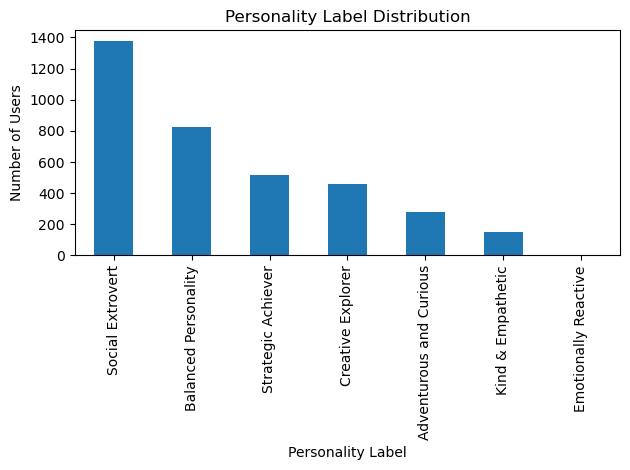

In [166]:
import matplotlib.pyplot as plt

plt.figure()
final_df["personality_label"].value_counts().plot(kind="bar")
plt.title("Personality Label Distribution")
plt.xlabel("Personality Label")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()
